In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lime

from sklearn.preprocessing import StandardScaler, OneHotEncoder,  LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error as m_a_e, mean_squared_error as m_s_e, r2_score as r2
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lime import lime_tabular

from scipy.stats.mstats import winsorize

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
dataset = "E:/Formation Data Scientist/Projet_4/2016_Building_Energy_Benchmarking.csv"

In [4]:
df = pd.read_csv(dataset)

## <a name='C2'> EDA et Choix des features   </a>

In [5]:
df.head(3)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

In [7]:
df.shape

(3376, 46)

- Exploration des valeurs nulles

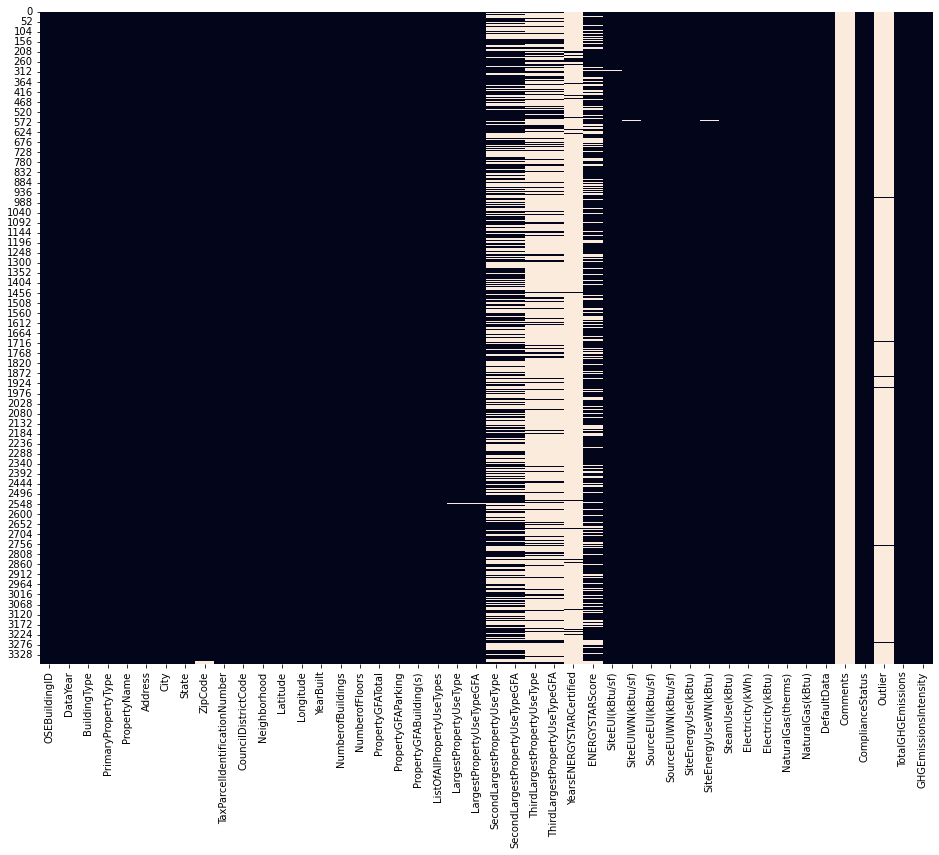

In [8]:
plt.figure(figsize=(16,12))
sns.heatmap(df.isna(),cbar=False)
plt.show()

<AxesSubplot:xlabel='SiteEnergyUse(kBtu)'>

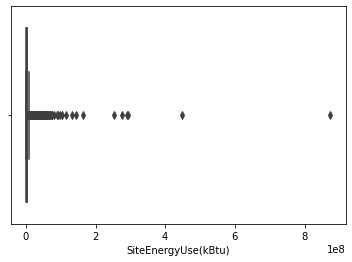

In [9]:
sns.boxplot(x=df['SiteEnergyUse(kBtu)'])

<AxesSubplot:xlabel='TotalGHGEmissions'>

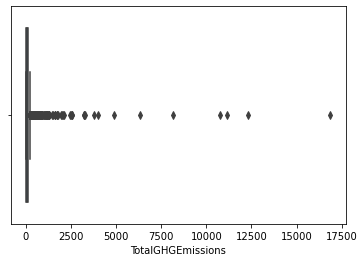

In [10]:
sns.boxplot(x=df['TotalGHGEmissions'])

- Typologie des variables

In [11]:
df.dtypes.value_counts()

float64    22
object     15
int64       8
bool        1
dtype: int64

In [12]:
df_cat = df.select_dtypes(include='object').copy()
df_cat.head(1)

,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,TaxParcelIdentificationNumber,Neighborhood,ListOfAllPropertyUseTypes,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,YearsENERGYSTARCertified,ComplianceStatus,Outlier
0,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,0659000030,DOWNTOWN,Hotel,Hotel,NaN,NaN,NaN,Compliant,NaN


In [13]:
df_cat['SiteEnergyUse'] = df.loc[df_cat.index, 'SiteEnergyUse(kBtu)'].copy()
df_cat['GHGEmissions'] = df.loc[df_cat.index, 'TotalGHGEmissions'].copy()

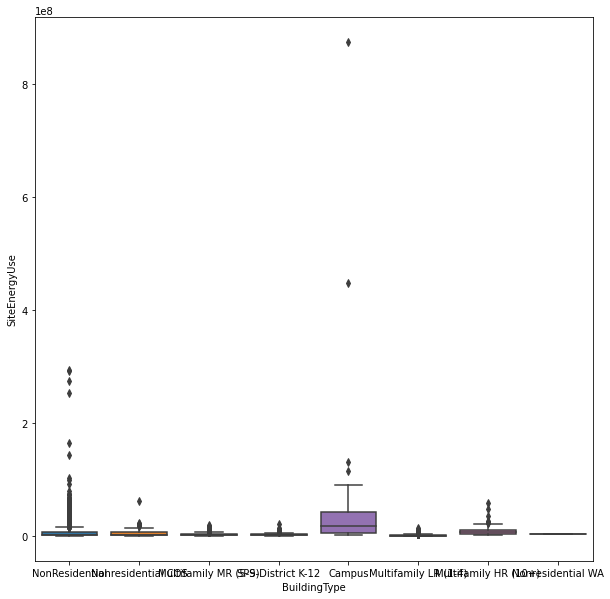

In [14]:
plt.figure(figsize=(10,10))
sns.boxplot(data=df_cat, x='BuildingType',y='SiteEnergyUse')
plt.show()

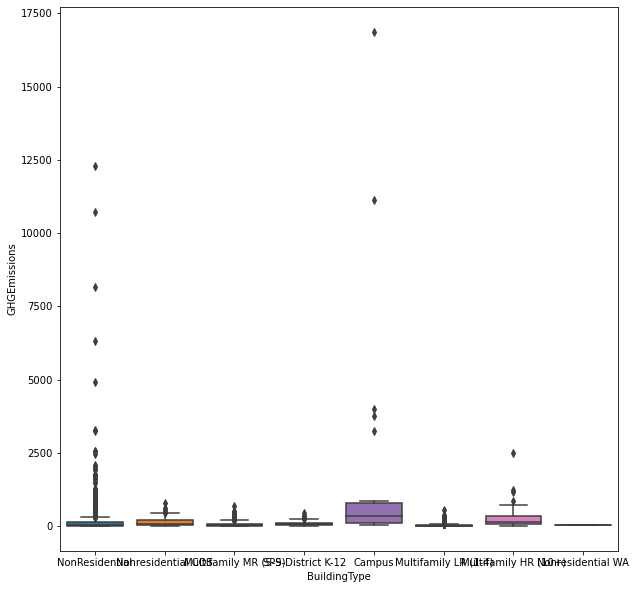

In [15]:
plt.figure(figsize=(10,10))
sns.boxplot(data=df_cat, x='BuildingType',y='GHGEmissions')
plt.show()

- Nombre de variables différentes par Feature

In [16]:
df.nunique()

OSEBuildingID                      3376
DataYear                              1
BuildingType                          8
PrimaryPropertyType                  24
PropertyName                       3362
Address                            3354
City                                  1
State                                 1
ZipCode                              55
TaxParcelIdentificationNumber      3268
CouncilDistrictCode                   7
Neighborhood                         19
Latitude                           2876
Longitude                          2656
YearBuilt                           113
NumberofBuildings                    17
NumberofFloors                       50
PropertyGFATotal                   3195
PropertyGFAParking                  496
PropertyGFABuilding(s)             3193
ListOfAllPropertyUseTypes           466
LargestPropertyUseType               56
LargestPropertyUseTypeGFA          3122
SecondLargestPropertyUseType         50
SecondLargestPropertyUseTypeGFA    1352


In [17]:
df['Outlier'].value_counts()

Low outlier     23
High outlier     9
Name: Outlier, dtype: int64

In [18]:
df['ComplianceStatus'].value_counts()

Compliant                       3211
Error - Correct Default Data     113
Non-Compliant                     37
Missing Data                      15
Name: ComplianceStatus, dtype: int64

On a 8 types de buiding, seuls les buildings résidentiels nous interressent dans le cadre de notre étude

In [19]:
df.iloc[:,2].value_counts()

NonResidential          1460
Multifamily LR (1-4)    1018
Multifamily MR (5-9)     580
Multifamily HR (10+)     110
SPS-District K-12         98
Nonresidential COS        85
Campus                    24
Nonresidential WA          1
Name: BuildingType, dtype: int64

Ici ce sont les buildings de type Multifamily qui nous interressent (rajouter Campus??)

In [20]:
df.iloc[:,3].value_counts()

Low-Rise Multifamily           987
Mid-Rise Multifamily           564
Small- and Mid-Sized Office    293
Other                          256
Warehouse                      187
Large Office                   173
K-12 School                    139
Mixed Use Property             133
High-Rise Multifamily          105
Retail Store                    91
Hotel                           77
Worship Facility                71
Distribution Center             53
Senior Care Community           45
Supermarket / Grocery Store     40
Medical Office                  39
Self-Storage Facility           28
University                      25
Residence Hall                  23
Refrigerated Warehouse          12
Restaurant                      12
Hospital                        10
Laboratory                      10
Office                           3
Name: PrimaryPropertyType, dtype: int64

- Nombre de valeures nulles par feature

In [21]:
df.isna().sum()

OSEBuildingID                         0
DataYear                              0
BuildingType                          0
PrimaryPropertyType                   0
PropertyName                          0
Address                               0
City                                  0
State                                 0
ZipCode                              16
TaxParcelIdentificationNumber         0
CouncilDistrictCode                   0
Neighborhood                          0
Latitude                              0
Longitude                             0
YearBuilt                             0
NumberofBuildings                     8
NumberofFloors                        0
PropertyGFATotal                      0
PropertyGFAParking                    0
PropertyGFABuilding(s)                0
ListOfAllPropertyUseTypes             9
LargestPropertyUseType               20
LargestPropertyUseTypeGFA            20
SecondLargestPropertyUseType       1697
SecondLargestPropertyUseTypeGFA    1697


## <a name='C2'> Feature Engineering   </a>

In [22]:
building_type = ['NonResidential','NonResidential COS','NonResidential WA','Campus','SPS-District K-12'] 

nonRes = df[df['BuildingType'].isin(building_type)].reset_index(drop=True)

- Nos deux targets sont **TotalGHGEmissions** et **SiteEnergyUse(kBtu)**

In [23]:
compliant = ['Compliant']

nonRes = nonRes[nonRes['ComplianceStatus'].isin(compliant)].reset_index(drop=True)

In [24]:
nonRes.shape

(1466, 46)

In [25]:
nonRes.head(1)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1156514.25,3946027.0,12764.5293,1276453.0,False,NaN,Compliant,NaN,249.98,2.83


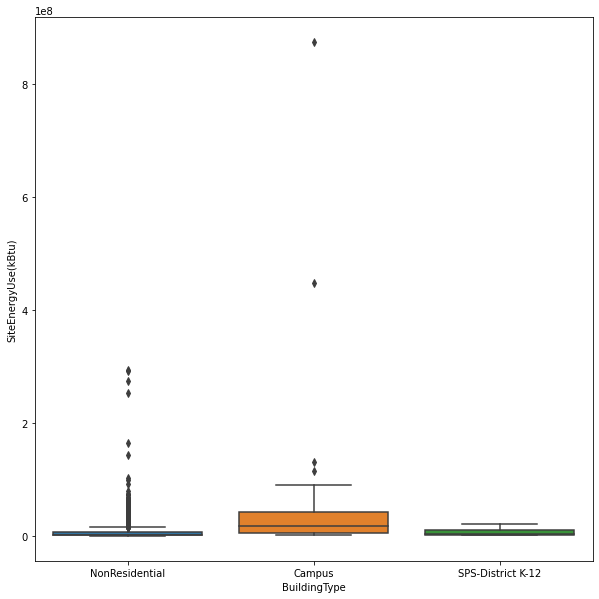

In [26]:
plt.figure(figsize=(10,10))
sns.boxplot(data=nonRes, x='BuildingType',y='SiteEnergyUse(kBtu)')
plt.show()

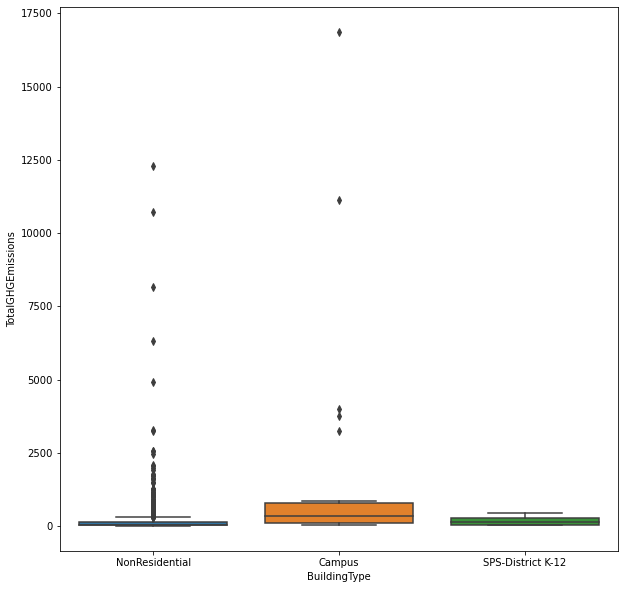

In [27]:
plt.figure(figsize=(10,10))
sns.boxplot(data=nonRes, x='BuildingType',y='TotalGHGEmissions')
plt.show()

In [28]:
#nonRes[nonRes['BuildingType'] == 'Campus']

In [29]:
nonRes.iloc[:,3].value_counts()

Small- and Mid-Sized Office    282
Other                          190
Warehouse                      178
Large Office                   165
Mixed Use Property             105
Retail Store                    85
Hotel                           75
Worship Facility                69
Distribution Center             51
K-12 School                     50
Supermarket / Grocery Store     40
Medical Office                  38
Self-Storage Facility           28
University                      23
Residence Hall                  21
Senior Care Community           20
Refrigerated Warehouse          12
Restaurant                      12
Hospital                        10
Laboratory                      10
Low-Rise Multifamily             2
Name: PrimaryPropertyType, dtype: int64

- Nettoyage et choix des features à utiliser

In [30]:
nonRes = nonRes.drop(nonRes[nonRes['PrimaryPropertyType'] == 'Low-Rise Multifamily'].index)
nonRes = nonRes.drop(nonRes[nonRes['PrimaryPropertyType'] == 'Residence Hall'].index)
#nonRes = nonRes.drop(nonRes[nonRes['PrimaryPropertyType'] == 'Other'].index)

In [31]:
nonRes.iloc[:,3].value_counts()

Small- and Mid-Sized Office    282
Other                          190
Warehouse                      178
Large Office                   165
Mixed Use Property             105
Retail Store                    85
Hotel                           75
Worship Facility                69
Distribution Center             51
K-12 School                     50
Supermarket / Grocery Store     40
Medical Office                  38
Self-Storage Facility           28
University                      23
Senior Care Community           20
Refrigerated Warehouse          12
Restaurant                      12
Hospital                        10
Laboratory                      10
Name: PrimaryPropertyType, dtype: int64

In [32]:
nonRes.isna().sum()

OSEBuildingID                         0
DataYear                              0
BuildingType                          0
PrimaryPropertyType                   0
PropertyName                          0
Address                               0
City                                  0
State                                 0
ZipCode                               0
TaxParcelIdentificationNumber         0
CouncilDistrictCode                   0
Neighborhood                          0
Latitude                              0
Longitude                             0
YearBuilt                             0
NumberofBuildings                     0
NumberofFloors                        0
PropertyGFATotal                      0
PropertyGFAParking                    0
PropertyGFABuilding(s)                0
ListOfAllPropertyUseTypes             0
LargestPropertyUseType                4
LargestPropertyUseTypeGFA             4
SecondLargestPropertyUseType        654
SecondLargestPropertyUseTypeGFA     654


In [33]:
nonRes['ComplianceStatus'].value_counts()

Compliant    1443
Name: ComplianceStatus, dtype: int64

In [34]:
nonRes['Outlier'].value_counts()

Series([], Name: Outlier, dtype: int64)

In [35]:
nonRes = nonRes[nonRes.Outlier.isnull()]

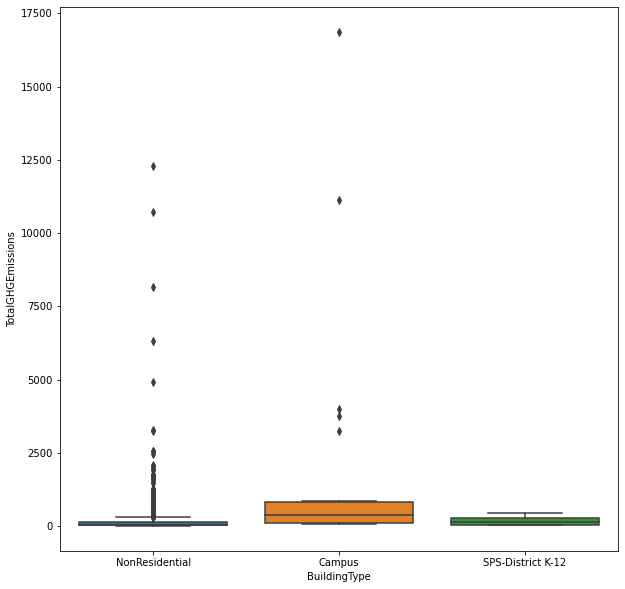

In [36]:
plt.figure(figsize=(10,10))
sns.boxplot(data=nonRes, x='BuildingType',y='TotalGHGEmissions')
plt.show()

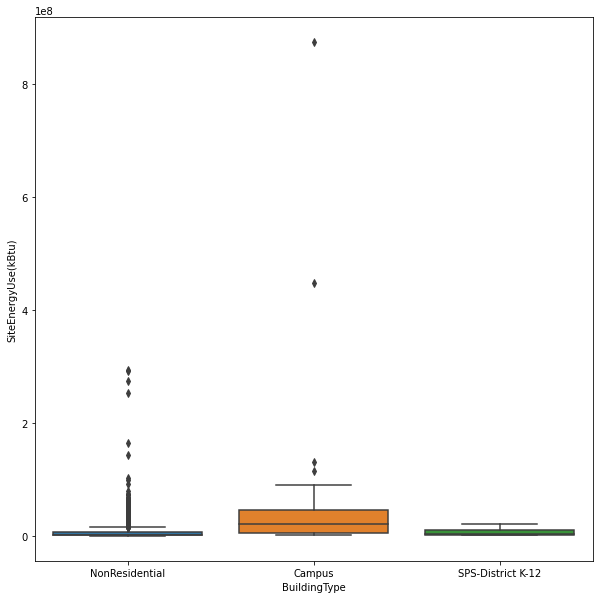

In [37]:
plt.figure(figsize=(10,10))
sns.boxplot(data=nonRes, x='BuildingType',y='SiteEnergyUse(kBtu)')
plt.show()

In [38]:
nonResidential = nonRes[['PrimaryPropertyType','Latitude','Longitude','YearBuilt','NumberofBuildings','NumberofFloors'\
            ,'PropertyGFABuilding(s)','PropertyGFAParking','LargestPropertyUseTypeGFA','SteamUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)','TotalGHGEmissions','SiteEnergyUse(kBtu)']]

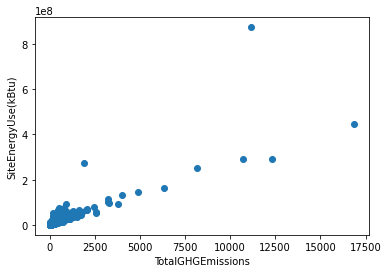

In [39]:
plt.scatter(nonResidential['TotalGHGEmissions'],nonResidential['SiteEnergyUse(kBtu)'])
plt.xlabel('TotalGHGEmissions')
plt.ylabel('SiteEnergyUse(kBtu)')
plt.show()

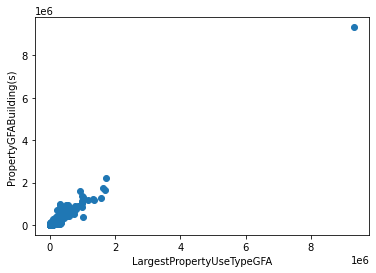

In [40]:
plt.scatter(nonResidential['LargestPropertyUseTypeGFA'],nonResidential['PropertyGFABuilding(s)'])
plt.xlabel('LargestPropertyUseTypeGFA')
plt.ylabel('PropertyGFABuilding(s)')
plt.show()

In [41]:
nonResidential[nonResidential['SiteEnergyUse(kBtu)'] > 200000000]
# Index des outliers à virer: 1443, 475,28

,PrimaryPropertyType,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),PropertyGFAParking,LargestPropertyUseTypeGFA,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,SiteEnergyUse(kBtu)
28,Mixed Use Property,47.534930,-122.317880,1992,1.0,3,494835,0,757027.0,0.0,150476283.0,297909000.0,16870.98,448385312.0
92,Hospital,47.662310,-122.281460,1953,6.0,10,879000,0,879000.0,0.0,115641210.0,138191238.0,8145.52,253832464.0
117,Hospital,47.603990,-122.323770,2000,9.0,8,1158691,0,1350182.0,122575032.0,168683602.0,1832129.0,10734.57,293090784.0
475,Other,47.614380,-122.338710,1981,1.0,33,429405,0,218997.0,0.0,274532495.0,149672.0,1921.82,274682208.0
532,Hospital,47.608951,-122.322402,1994,7.0,14,1765970,0,1639334.0,134943456.0,139354828.0,17316120.0,12307.16,291614432.0
1443,University,47.656440,-122.310410,1900,111.0,0,9320156,0,9320156.0,84985240.0,657074389.0,0.0,11140.56,873923712.0


- Drop des Outliers

In [42]:
nonResidential[nonResidential['TotalGHGEmissions'] > 10000]

,PrimaryPropertyType,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),PropertyGFAParking,LargestPropertyUseTypeGFA,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,SiteEnergyUse(kBtu)
28,Mixed Use Property,47.534930,-122.317880,1992,1.0,3,494835,0,757027.0,0.0,150476283.0,297909000.0,16870.98,448385312.0
117,Hospital,47.603990,-122.323770,2000,9.0,8,1158691,0,1350182.0,122575032.0,168683602.0,1832129.0,10734.57,293090784.0
532,Hospital,47.608951,-122.322402,1994,7.0,14,1765970,0,1639334.0,134943456.0,139354828.0,17316120.0,12307.16,291614432.0
1443,University,47.656440,-122.310410,1900,111.0,0,9320156,0,9320156.0,84985240.0,657074389.0,0.0,11140.56,873923712.0


In [43]:
# suppression des valeurs GHGE > 10000
#nonResidential = nonResidential[nonResidential['TotalGHGEmissions'] < 10000]

In [44]:
# suppression des valeurs energy > 600000000
#nonResidential = nonResidential[nonResidential['SiteEnergyUse(kBtu)'] < 250000000]

In [45]:
nonResidential = nonResidential.drop([1443, 475,28], axis = 0)

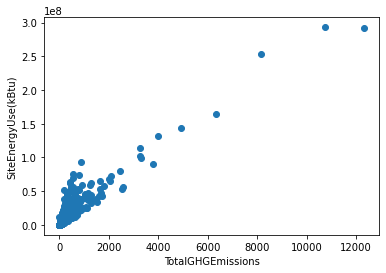

In [46]:
plt.scatter(nonResidential['TotalGHGEmissions'],nonResidential['SiteEnergyUse(kBtu)'])
plt.xlabel('TotalGHGEmissions')
plt.ylabel('SiteEnergyUse(kBtu)')
plt.show()

In [47]:
nonResidential.isna().sum()

PrimaryPropertyType          0
Latitude                     0
Longitude                    0
YearBuilt                    0
NumberofBuildings            0
NumberofFloors               0
PropertyGFABuilding(s)       0
PropertyGFAParking           0
LargestPropertyUseTypeGFA    4
SteamUse(kBtu)               0
Electricity(kBtu)            0
NaturalGas(kBtu)             0
TotalGHGEmissions            0
SiteEnergyUse(kBtu)          0
dtype: int64

In [48]:
nonResidential[nonResidential['LargestPropertyUseTypeGFA'].isna()]

,PrimaryPropertyType,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),PropertyGFAParking,LargestPropertyUseTypeGFA,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,SiteEnergyUse(kBtu)
281,Self-Storage Facility,47.66838,-122.39310,1946,2.0,2,111445,0,NaN,0.0,3007514.0,2689958.0,163.83,5.697472e+06
726,Hotel,47.61203,-122.34165,1910,1.0,8,61721,0,NaN,0.0,2534592.0,362488.0,36.92,2.897080e+06
1201,Small- and Mid-Sized Office,47.64747,-122.34086,2008,1.0,4,48350,0,NaN,0.0,3168131.0,0.0,22.09,3.168131e+06
1217,Restaurant,47.59697,-122.32474,1913,1.0,3,28800,0,NaN,0.0,402907.0,497017.0,29.21,8.999242e+05


In [49]:
nonResidential['PrimaryPropertyType'].value_counts()

Small- and Mid-Sized Office    282
Other                          189
Warehouse                      178
Large Office                   165
Mixed Use Property             104
Retail Store                    85
Hotel                           75
Worship Facility                69
Distribution Center             51
K-12 School                     50
Supermarket / Grocery Store     40
Medical Office                  38
Self-Storage Facility           28
University                      22
Senior Care Community           20
Refrigerated Warehouse          12
Restaurant                      12
Hospital                        10
Laboratory                      10
Name: PrimaryPropertyType, dtype: int64

In [50]:
nonResidential = nonResidential.dropna(axis=0) 

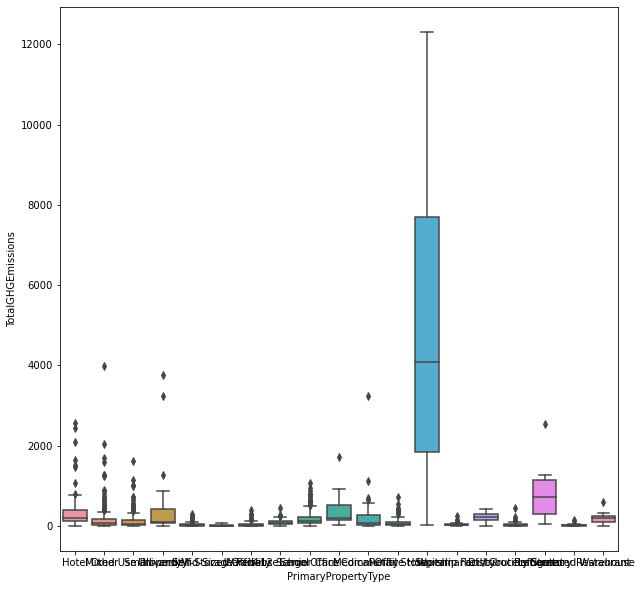

In [51]:
plt.figure(figsize=(10,10))
sns.boxplot(data=nonResidential, x='PrimaryPropertyType',y='TotalGHGEmissions')
plt.show()

In [52]:
nonResidential['NumberofBuildings'].value_counts()

1.0     1346
0.0       44
3.0       12
2.0       11
5.0        6
4.0        4
6.0        4
14.0       2
27.0       1
11.0       1
9.0        1
7.0        1
8.0        1
23.0       1
10.0       1
Name: NumberofBuildings, dtype: int64

- Calcul de l'age des batiments

In [53]:
nonResidential.dtypes

PrimaryPropertyType           object
Latitude                     float64
Longitude                    float64
YearBuilt                      int64
NumberofBuildings            float64
NumberofFloors                 int64
PropertyGFABuilding(s)         int64
PropertyGFAParking             int64
LargestPropertyUseTypeGFA    float64
SteamUse(kBtu)               float64
Electricity(kBtu)            float64
NaturalGas(kBtu)             float64
TotalGHGEmissions            float64
SiteEnergyUse(kBtu)          float64
dtype: object

In [54]:
df1 = nonResidential.copy()

In [55]:
def fill_date(data):
    if data<= 1920:
        return "_1920"
    elif 1920<data<=1940:
        return "1920_1940"
    elif 1940<data<=1960:
        return "1940_1960"
    elif 1960<data<=1980:
        return "1960_1980"
    elif 1980<data<=2000:
        return "1980_2000"
    elif data>2000:
        return "2000_"

In [56]:
df1.dtypes

PrimaryPropertyType           object
Latitude                     float64
Longitude                    float64
YearBuilt                      int64
NumberofBuildings            float64
NumberofFloors                 int64
PropertyGFABuilding(s)         int64
PropertyGFAParking             int64
LargestPropertyUseTypeGFA    float64
SteamUse(kBtu)               float64
Electricity(kBtu)            float64
NaturalGas(kBtu)             float64
TotalGHGEmissions            float64
SiteEnergyUse(kBtu)          float64
dtype: object

In [57]:
df1['YearBuilt'] = df1['YearBuilt'].apply(fill_date)

In [58]:
df1['SteamUse(kBtu)'] = df1['SteamUse(kBtu)'].apply(lambda x : 1 if x > 0 else 0 )
df1['Electricity(kBtu)'] = df1['Electricity(kBtu)'].apply(lambda x : 1 if x > 0 else 0 )
df1['NaturalGas(kBtu)'] = df1['NaturalGas(kBtu)'].apply(lambda x : 1 if x > 0 else 0 )

In [59]:
df1.shape

(1436, 14)

In [60]:
df2_code = pd.get_dummies(df1 ,columns=['PrimaryPropertyType','YearBuilt'])

In [61]:
df2_code.shape

(1436, 37)

In [62]:
def undummify(df, prefix_sep="_"):
    cols2collapse = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df

In [63]:
test = undummify(df2_code)

In [64]:
test

,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),PropertyGFAParking,LargestPropertyUseTypeGFA,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,SiteEnergyUse(kBtu),PrimaryPropertyType,YearBuilt
0,47.61220,-122.33799,1.0,12,88434,0,88434.0,1,1,1,249.98,7226362.50,Hotel,1920_1940
1,47.61317,-122.33393,1.0,11,88502,15064,83880.0,0,1,1,295.86,8387933.00,Hotel,1980_2000
2,47.61393,-122.33810,1.0,41,759392,196718,756493.0,1,1,1,2089.28,72587024.00,Hotel,1960_1980
3,47.61412,-122.33664,1.0,10,61320,0,61320.0,1,1,1,286.43,6794584.00,Hotel,1920_1940
4,47.61375,-122.34047,1.0,18,113580,62000,123445.0,0,1,1,505.01,14172606.00,Hotel,1960_1980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1461,47.54425,-122.31776,1.0,1,47863,4222,52085.0,0,1,1,157.70,3605855.50,Warehouse,1940_1960
1462,47.53161,-122.29944,1.0,2,24990,0,24990.0,0,1,1,134.80,4420650.50,Small- and Mid-Sized Office,1920_1940
1463,47.68109,-122.26180,1.0,1,72000,0,72000.0,0,1,1,67.65,2925780.00,Other,2000_
1464,47.58831,-122.30650,1.0,3,45000,0,45728.0,0,1,0,9.24,1325972.75,K-12 School,2000_


In [65]:
features = df2_code.drop(columns = ["TotalGHGEmissions","SiteEnergyUse(kBtu)"])
features_ESS = df2_code.drop(columns = ["TotalGHGEmissions","SiteEnergyUse(kBtu)"]).join(df.ENERGYSTARScore)

In [66]:
features_names = features.columns
features_ESS_names = features_ESS.columns

In [67]:
features_ESS_names.shape


(36,)

In [68]:
features_names.shape

(35,)

In [69]:
train, test = train_test_split(df2_code, test_size=0.3, random_state=0) 

In [70]:
X1_train, y1_train, X1_test, y1_test = train.drop(columns = ["TotalGHGEmissions","SiteEnergyUse(kBtu)"]), train["TotalGHGEmissions"],test.drop(columns = ["TotalGHGEmissions",'SiteEnergyUse(kBtu)']) ,test["TotalGHGEmissions"]
X2_train, y2_train, X2_test, y2_test = train.drop(columns = ["TotalGHGEmissions","SiteEnergyUse(kBtu)"]), train["SiteEnergyUse(kBtu)"],test.drop(columns = ["TotalGHGEmissions",'SiteEnergyUse(kBtu)']) ,test["SiteEnergyUse(kBtu)"]

## <a name='C2'> Prédictions de TotalGHGEmissions   </a>

In [71]:
""" scaler = StandardScaler()
scaler.fit(X1_train)
X1_train = scaler.transform(X1_train)
X1_test = scaler.transform(X1_test) """

' scaler = StandardScaler()\nscaler.fit(X1_train)\nX1_train = scaler.transform(X1_train)\nX1_test = scaler.transform(X1_test) '

In [72]:
r_forest = RandomForestRegressor(random_state=0)

In [73]:
# entrainement du modèle
r_forest.fit(X1_train, y1_train)

RandomForestRegressor(random_state=0)

In [74]:
# prédiction
preds = r_forest.predict(X1_test)

# calcul du RMSE
print(m_s_e(y1_test,preds, squared=False))

415.38682999086365


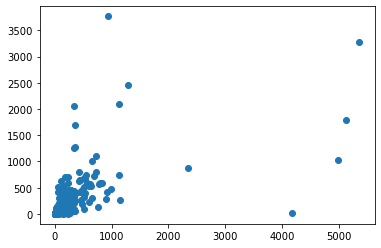

In [75]:
plt.scatter(preds,y1_test)

In [76]:
def get_error(n_estimator, X_train, X_test, y_train, y_test):
    model = RandomForestRegressor(n_estimators=n_estimator, random_state=12)
    model.fit(X_train, y_train)
    preds_val = model.predict(X_test)
    rmse = m_s_e(y_test, preds_val,squared=False)
    mae = m_a_e(y_test, preds_val)
    r_2 = r2(y_test,preds_val)
    return(rmse, mae, r_2)

In [77]:
# comparer RMSE et r2 avec differents valeurs de n_estimator
lst_rmse = []
lst_mae = []
lst_r2 = []
for n_estimator in [100, 200, 300, 400, 500]:
    my_rmse = get_error(n_estimator, X1_train, X1_test, y1_train, y1_test)
    lst_rmse.append(my_rmse[0])
    lst_mae.append(my_rmse[1])
    lst_r2.append(my_rmse[2])
    print("N_Estimator: %d  \t\t RMSE:  %f  \t\t MAE: %f  \t\t R2:  %f" %(n_estimator, my_rmse[0], my_rmse[1], my_rmse[2]))

N_Estimator: 100  		 RMSE:  433.950284  		 MAE: 126.838361  		 R2:  -0.404685
N_Estimator: 200  		 RMSE:  435.235791  		 MAE: 128.603843  		 R2:  -0.413020
N_Estimator: 300  		 RMSE:  433.593861  		 MAE: 128.429344  		 R2:  -0.402378
N_Estimator: 400  		 RMSE:  427.836104  		 MAE: 127.586125  		 R2:  -0.365381
N_Estimator: 500  		 RMSE:  429.527922  		 MAE: 127.926610  		 R2:  -0.376201


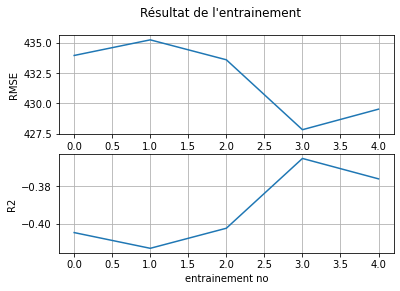

In [78]:
fig,(ax1,ax2) = plt.subplots(2,1)
fig.suptitle('Résultat de l\'entrainement')

ax1.plot(lst_rmse)
ax1.set_ylabel('RMSE')
ax1.set_xlabel('entrainement no')
ax1.grid()

ax2.plot(lst_r2)
ax2.set_ylabel('R2')
ax2.set_xlabel('entrainement no')
ax2.grid()

plt.show()

In [79]:
scores = []
best_scores = []

In [80]:
dummy_param_grid = {'strategy' : ['mean','median']}

In [81]:
CV_dummy_mean = GridSearchCV(estimator=DummyRegressor(), param_grid=dummy_param_grid, cv= 5,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
CV_dummy_mean.fit(X1_train, y1_train)

GridSearchCV(cv=5, estimator=DummyRegressor(),
             param_grid={'strategy': ['mean', 'median']}, refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [82]:
CV_dummy_mean.best_score_

-0.0005713012098950809

In [83]:
dummy_model = CV_dummy_mean.best_estimator_

In [84]:
dummy_model.score(X1_test,y1_test)

-0.001513969855813091

In [85]:
print(f"Score - training data: {round(CV_dummy_mean.score(X1_train,y1_train)*100,2)} %")
print(f"Score - test data: {round(CV_dummy_mean.score(X1_test,y1_test)*100,2)} %")

Score - training data: 0.0 %
Score - test data: -0.15 %


In [86]:
scores.append(dummy_model.score(X1_test,y1_test))
best_scores.append(CV_dummy_mean.best_score_)

In [87]:
res_dummy = pd.DataFrame(CV_dummy_mean.cv_results_)

### - Dummy Regressor

### - Random Forest Regressor


In [88]:
rfc_param_grid = {'n_estimators' : [100,200,300,400,500],
              'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth' : [4,5,6,7,8],
              'random_state': [12]}

In [89]:
CV_rfc = GridSearchCV(estimator=RandomForestRegressor(), param_grid=rfc_param_grid, cv= 5,scoring=['r2','neg_mean_squared_error','neg_root_mean_squared_error'],refit='r2')
CV_rfc.fit(X1_train, y1_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 400, 500],
                         'random_state': [12]},
             refit='r2',
             scoring=['r2', 'neg_mean_squared_error',
                      'neg_root_mean_squared_error'])

In [90]:
CV_rfc.best_params_

{'max_depth': 7,
 'max_features': 'auto',
 'n_estimators': 100,
 'random_state': 12}

In [91]:
CV_rfc.best_score_

0.7366776899800328

In [92]:
rfc_model= CV_rfc.best_estimator_

In [93]:
rfc_model.score(X1_test,y1_test)

-0.3606677829806988

In [94]:
print(f"Score - training data: {round(CV_rfc.score(X1_train,y1_train)*100,1)} %")
print(f"Score - test data: {round(CV_rfc.score(X1_test,y1_test)*100,1)} %")

Score - training data: 95.1 %
Score - test data: -36.1 %


In [95]:
scores.append(rfc_model.score(X1_test,y1_test))
best_scores.append(CV_rfc.best_score_)

In [96]:
res_forest = pd.DataFrame(CV_rfc.cv_results_)

### - Ridge Regressor

In [97]:
ridge_param_grid = {'alpha' : [1e-3, 1e-2, 1e-1, 1, 2, 5, 10],
              }

In [98]:
CV_ridge = GridSearchCV(estimator=Ridge(), param_grid=ridge_param_grid, cv= 5,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
CV_ridge.fit(X1_train, y1_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 2, 5, 10]}, refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [99]:
CV_ridge.best_score_

0.7584981415859533

In [100]:
model_ridge = CV_ridge.best_estimator_
print(model_ridge)

Ridge(alpha=0.1)


In [101]:
model_ridge.score(X1_test,y1_test)

-0.7936537401770853

In [102]:
print(f"Score - training data: {round(CV_ridge.score(X1_train,y1_train)*100,1)} %")
print(f"Score - test data: {round(CV_ridge.score(X1_test,y1_test)*100,1)} %")

Score - training data: 81.6 %
Score - test data: -79.4 %


In [103]:
scores.append(model_ridge.score(X1_test,y1_test))
best_scores.append(CV_ridge.best_score_)

In [104]:
res_ridge = pd.DataFrame(CV_ridge.cv_results_)

### - KNN Regressor

In [105]:
knn_param_grid = {'n_neighbors' : list(range(10, 100)),
              }

In [106]:
CV_knn = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=knn_param_grid, cv= 6,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
CV_knn.fit(X1_train, y1_train)

GridSearchCV(cv=6, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
                                         20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
                                         30, 31, 32, 33, 34, 35, 36, 37, 38, 39, ...]},
             refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [107]:
CV_knn.best_score_

0.20053520792753968

In [108]:
model_knn = CV_knn.best_estimator_

In [109]:
model_knn.score(X1_test,y1_test)

0.30707216828941175

In [110]:
print(f"Score - training data: {round(CV_knn.score(X1_train,y1_train)*100,1)} %")
print(f"Score - test data: {round(CV_knn.score(X1_test,y1_test)*100,1)} %")

Score - training data: 18.2 %
Score - test data: 30.7 %


In [111]:
scores.append(model_knn.score(X1_test,y1_test))
best_scores.append(CV_knn.best_score_)

In [112]:
CV_knn.best_params_

{'n_neighbors': 93}

In [113]:
res_knn = pd.DataFrame(CV_knn.cv_results_)

### - XGBoost

In [114]:
xgboost_param_grid = {'n_estimators' : [100,200,300,400,500],
              'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth' : [4,5,6,7,8],
              'random_state': [12]}

In [115]:
CV_xgboost = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=xgboost_param_grid, cv= 5,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
CV_xgboost.fit(X1_train, y1_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 400, 500],
                         'random_state': [12]},
             refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [116]:
CV_xgboost.best_score_

0.7767598593864128

In [117]:
model_boosted = CV_xgboost.best_estimator_

In [118]:
model_boosted.score(X1_test,y1_test)

0.5226211902131058

In [119]:
y_pred = model_boosted.predict(X1_test)

In [120]:
predictions = pd.DataFrame({'Actual': y1_test,
                           'Predicted': y_pred})

In [121]:
predictions

,Actual,Predicted
661,100.21,102.548310
415,40.38,72.972223
346,57.73,118.619152
1321,92.52,186.364423
488,639.72,413.134744
...,...,...
1066,17.87,11.526450
1397,37.83,52.139029
555,31.74,15.027839
878,208.53,229.508655


In [122]:
def get_errors(y_test,y_pred):
    rmse = m_s_e(y_test, y_pred,squared=False)
    mae = m_a_e(y_test, y_pred)
    r_2 = r2(y_test,y_pred)
    mean_ = np.mean(y1_test)
    return (r_2, rmse, mae, mean_)
""" pd.DataFrame({'RMSE: ': rmse,
                         'MAE: ': mae,
                         'R^2: ': r_2,
                         'Mean: ': mean_}) """

" pd.DataFrame({'RMSE: ': rmse,\n                         'MAE: ': mae,\n                         'R^2: ': r_2,\n                         'Mean: ': mean_}) "

In [123]:
get_errors(y1_test,y_pred)

(0.5226211902131058,
 252.97761322483032,
 107.50810671819472,
 167.97591647331788)

In [124]:
CV_xgboost.best_params_

{'max_depth': 6,
 'max_features': 'sqrt',
 'n_estimators': 200,
 'random_state': 12}

In [125]:
print(f"Score - training data: {round(CV_xgboost.score(X1_train,y1_train)*100,1)} %")
print(f"Score - test data: {round(CV_xgboost.score(X1_test,y1_test)*100,1)} %")

Score - training data: 99.9 %
Score - test data: 52.3 %


In [126]:
model_boosted.feature_importances_

array([2.13516676e-02, 7.74309539e-02, 6.57894435e-02, 7.16953341e-02,
       1.17476274e-01, 2.58052397e-02, 1.67568553e-01, 3.64797244e-02,
       2.87582609e-04, 4.44188495e-03, 4.00290797e-05, 3.39448488e-01,
       4.56940848e-03, 3.37508526e-05, 7.49434896e-03, 5.38967761e-03,
       2.59369422e-03, 1.55138626e-03, 1.42379283e-03, 8.88684698e-06,
       1.57002151e-04, 1.10547800e-03, 1.66279994e-04, 2.85667832e-03,
       3.98702983e-03, 9.53571394e-04, 2.53091860e-03, 8.24025778e-04,
       1.24450807e-04, 9.91530609e-03, 5.99986990e-03, 1.29406292e-03,
       1.52451057e-02, 2.00387213e-03, 1.95622726e-03])

    Feature Importance                                     Feature Name
11            0.339448                     PrimaryPropertyType_Hospital
6             0.167569                        LargestPropertyUseTypeGFA
4             0.117476                           PropertyGFABuilding(s)
1             0.077431                                        Longitude
3             0.071695                                   NumberofFloors
2             0.065789                                NumberofBuildings
7             0.036480                                   SteamUse(kBtu)
5             0.025805                               PropertyGFAParking
0             0.021352                                         Latitude
32            0.015245                              YearBuilt_1980_2000
29            0.009915                              YearBuilt_1920_1940
14            0.007494                   PrimaryPropertyType_Laboratory
30            0.006000                              YearBuilt_19

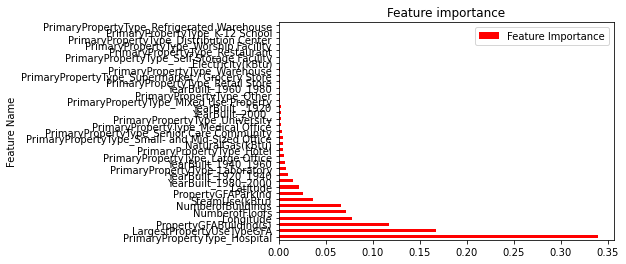

In [127]:
def display_feat_imp_xgboost(boosted):
  feat_imp = model_boosted.feature_importances_
  df_featimp = pd.DataFrame(feat_imp, columns = {"Feature Importance"})
  df_featimp["Feature Name"] = features_names
  df_featimp = df_featimp.sort_values(by="Feature Importance", ascending=False)
  print(df_featimp)
  df_featimp.plot.barh(y="Feature Importance", x="Feature Name", title="Feature importance", color="red")
 
display_feat_imp_xgboost(model_boosted)

In [128]:
reversed_X1_train= undummify(X1_train)
reversed_X1_test= undummify(X1_test)

In [129]:
ghge_explainer = lime_tabular.LimeTabularExplainer(training_data=np.array(X1_train),
                                                   feature_names=features_names,
                                                   mode="regression",
                                                   feature_selection='auto',
                                                   random_state=0)

In [130]:
ghge_exp = ghge_explainer.explain_instance(data_row=pd.DataFrame(X1_test).iloc[50],
                                           predict_fn=CV_xgboost.predict)

In [131]:
ghge_exp.show_in_notebook(show_table=True)

In [132]:
scores.append(model_boosted.score(X1_test,y1_test))
best_scores.append(CV_xgboost.best_score_)

In [133]:
res_xgboost = pd.DataFrame(CV_xgboost.cv_results_)

In [134]:
index = ['Dummy','Random Forest','Ridge','KNN','XGBoost']
columns = ['test score']
columns_b = ['validation score']

In [135]:
df_scores = pd.DataFrame(data=scores,index=index,columns=columns)
df_best_scores = pd.DataFrame(data=best_scores,index=index,columns=columns_b)

In [136]:
df_scores

,test score
Dummy,-0.001514
Random Forest,-0.360668
Ridge,-0.793654
KNN,0.307072
XGBoost,0.522621


In [137]:
df_best_scores

,validation score
Dummy,-0.000571
Random Forest,0.736678
Ridge,0.758498
KNN,0.200535
XGBoost,0.776760


### Energy Star Score GHGE

In [138]:
energyStar_GHGE = nonRes[['PrimaryPropertyType','Latitude','Longitude','YearBuilt','NumberofBuildings','NumberofFloors'\
            ,'PropertyGFABuilding(s)','PropertyGFAParking','LargestPropertyUseTypeGFA','SteamUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)','TotalGHGEmissions','ENERGYSTARScore']]

In [139]:
df1.dtypes

PrimaryPropertyType           object
Latitude                     float64
Longitude                    float64
YearBuilt                     object
NumberofBuildings            float64
NumberofFloors                 int64
PropertyGFABuilding(s)         int64
PropertyGFAParking             int64
LargestPropertyUseTypeGFA    float64
SteamUse(kBtu)                 int64
Electricity(kBtu)              int64
NaturalGas(kBtu)               int64
TotalGHGEmissions            float64
SiteEnergyUse(kBtu)          float64
dtype: object

In [140]:
energyStar_GHGE = df1.join(df.ENERGYSTARScore)

In [141]:
energyStar_GHGE.shape

(1436, 15)

In [142]:
energyStar_GHGE = energyStar_GHGE.dropna(axis=0)

In [143]:
energyStar_GHGE.isna().sum()

PrimaryPropertyType          0
Latitude                     0
Longitude                    0
YearBuilt                    0
NumberofBuildings            0
NumberofFloors               0
PropertyGFABuilding(s)       0
PropertyGFAParking           0
LargestPropertyUseTypeGFA    0
SteamUse(kBtu)               0
Electricity(kBtu)            0
NaturalGas(kBtu)             0
TotalGHGEmissions            0
SiteEnergyUse(kBtu)          0
ENERGYSTARScore              0
dtype: int64

In [144]:
energyStar_GHGE.dtypes

PrimaryPropertyType           object
Latitude                     float64
Longitude                    float64
YearBuilt                     object
NumberofBuildings            float64
NumberofFloors                 int64
PropertyGFABuilding(s)         int64
PropertyGFAParking             int64
LargestPropertyUseTypeGFA    float64
SteamUse(kBtu)                 int64
Electricity(kBtu)              int64
NaturalGas(kBtu)               int64
TotalGHGEmissions            float64
SiteEnergyUse(kBtu)          float64
ENERGYSTARScore              float64
dtype: object

In [145]:
energyStar_GHGE['YearBuilt'] = energyStar_GHGE['YearBuilt'].apply(fill_date)

TypeError: '<=' not supported between instances of 'str' and 'int'

In [ ]:
energyStar_GHGE['SteamUse(kBtu)'] = energyStar_GHGE['SteamUse(kBtu)'].apply(lambda x : 1 if x > 0 else 0 )
energyStar_GHGE['Electricity(kBtu)'] = energyStar_GHGE['Electricity(kBtu)'].apply(lambda x : 1 if x > 0 else 0 )
energyStar_GHGE['NaturalGas(kBtu)'] = energyStar_GHGE['NaturalGas(kBtu)'].apply(lambda x : 1 if x > 0 else 0 )

In [ ]:
energyStar_GHGE_code = pd.get_dummies(energyStar_GHGE ,columns=['PrimaryPropertyType','YearBuilt'])

In [ ]:
energyStar_GHGE_features = energyStar_GHGE_code.drop(columns =['TotalGHGEmissions'])
energyStar_GHGE_features_names = energyStar_GHGE_features.columns

In [ ]:
energyStar_GHGE_features_names.shape

(37,)

In [ ]:
train_EStar_ghge, test_EStar_ghge = train_test_split(energyStar_GHGE_code, test_size=0.3, random_state=0) 

- Avec Energy Star Score

In [ ]:
Xe_train_ghge, ye_train_ghge, Xe_test_ghge, ye_test_ghge = train_EStar_ghge.drop(columns = ['TotalGHGEmissions']), train_EStar_ghge['TotalGHGEmissions'],test_EStar_ghge.drop(columns = ['TotalGHGEmissions']) ,test_EStar_ghge['TotalGHGEmissions']

In [ ]:
Xe_train_ghge.shape

(749, 37)

In [ ]:
# scaler = StandardScaler()
# scaler.fit(Xe_train_ghge)
# Xe_train_ghge = scaler.transform(Xe_train_ghge)
# Xe_test_ghge = scaler.transform(Xe_test_ghge)

In [ ]:
rfr_eStar_ghge = GradientBoostingRegressor(**CV_xgboost.best_params_)

In [ ]:
rfr_eStar_ghge.fit(Xe_train_ghge, ye_train_ghge)

GradientBoostingRegressor(max_depth=6, max_features='sqrt', n_estimators=200,
                          random_state=12)

In [ ]:
rfr_eStar_ghge.score(Xe_test_ghge,ye_test_ghge)

0.626112084700083

In [ ]:
rfr_eStar_ghge.feature_importances_.shape

(37,)

    Feature Importance                                     Feature Name
2         2.574190e-01                                NumberofBuildings
13        2.205716e-01                     PrimaryPropertyType_Hospital
10        1.558676e-01                              SiteEnergyUse(kBtu)
4         1.008032e-01                           PropertyGFABuilding(s)
6         8.255939e-02                        LargestPropertyUseTypeGFA
3         4.288361e-02                                   NumberofFloors
17        1.952436e-02                 PrimaryPropertyType_Large Office
1         1.857541e-02                                        Longitude
0         1.611295e-02                                         Latitude
34        1.488137e-02                              YearBuilt_1980_2000
32        1.192175e-02                              YearBuilt_1940_1960
35        9.967758e-03                                  YearBuilt_2000_
11        9.296641e-03                                  ENERGYST

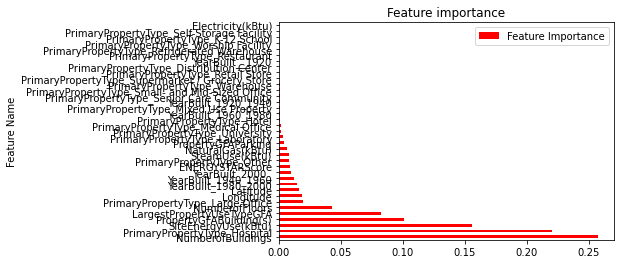

In [ ]:
def display_feat_imp_xgboost(boosted):
  feat_imp = rfr_eStar_ghge.feature_importances_
  df_featimp = pd.DataFrame(feat_imp, columns = {"Feature Importance"})
  df_featimp["Feature Name"] = energyStar_GHGE_features_names
  df_featimp = df_featimp.sort_values(by="Feature Importance", ascending=False)
  print(df_featimp)
  df_featimp.plot.barh(y="Feature Importance", x="Feature Name", title="Feature importance", color="red")
 
display_feat_imp_xgboost(rfr_eStar_ghge)

- Sans Energy Star Score

In [ ]:
Xee_train_ghge, yee_train_ghge, Xee_test_ghge, yee_test_ghge = train_EStar_ghge.drop(columns = ['TotalGHGEmissions','ENERGYSTARScore']), train_EStar_ghge['TotalGHGEmissions'],test_EStar_ghge.drop(columns = ['TotalGHGEmissions','ENERGYSTARScore']) ,test_EStar_ghge['TotalGHGEmissions']

In [ ]:
scaler = StandardScaler()
scaler.fit(Xee_train_ghge)
Xee_train_ghge = scaler.transform(Xee_train_ghge)
Xee_test_ghge = scaler.transform(Xee_test_ghge)

In [ ]:
rfr_eStar_ghge.fit(Xee_train_ghge,yee_train_ghge)

GradientBoostingRegressor(max_depth=6, max_features='sqrt', n_estimators=200,
                          random_state=12)

In [ ]:
rfr_eStar_ghge.score(Xee_test_ghge,yee_test_ghge)

0.5844481402434905

## <a name='C2'> Prédictions de SiteEnergyUse(kbtu)   </a>

### - Scaler

In [ ]:
scaler = StandardScaler()
scaler.fit(X2_train)
X2_train = scaler.transform(X2_train)
X2_test = scaler.transform(X2_test)

### - Dummy Regressor

In [ ]:
CV_dummy_en = GridSearchCV(estimator=DummyRegressor(), param_grid=dummy_param_grid, cv= 5,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
CV_dummy_en.fit(X2_train, y2_train)

GridSearchCV(cv=5, estimator=DummyRegressor(),
             param_grid={'strategy': ['mean', 'median']}, refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [ ]:
CV_dummy_en.best_score_

-0.00017351548195936316

In [ ]:
print(f"Score - training data: {round(CV_dummy_en.score(X2_train,y2_train)*100,2)} %")
print(f"Score - test data: {round(CV_dummy_en.score(X2_test,y2_test)*100,2)} %")

Score - training data: 0.0 %
Score - test data: -0.0 %


### - Random Forest

In [ ]:
CV_rfr_en = GridSearchCV(estimator=RandomForestRegressor(), param_grid=rfc_param_grid, cv= 5,scoring=['r2','neg_mean_squared_error','neg_root_mean_squared_error'],refit='r2')
CV_rfr_en.fit(X2_train, y2_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 400, 500],
                         'random_state': [12]},
             refit='r2',
             scoring=['r2', 'neg_mean_squared_error',
                      'neg_root_mean_squared_error'])

In [ ]:
CV_rfr_en.best_score_

0.7808264416279552

In [ ]:
print(f"Score - training data: {round(CV_rfr_en.score(X2_train,y2_train)*100,2)} %")
print(f"Score - test data: {round(CV_rfr_en.score(X2_test,y2_test)*100,2)} %")

Score - training data: 94.81 %
Score - test data: 43.71 %


### - Ridge Regressor

In [ ]:
CV_ridge_en = GridSearchCV(estimator=Ridge(), param_grid=ridge_param_grid, cv= 5,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
CV_ridge_en.fit(X2_train, y2_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 2, 5, 10]}, refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [ ]:
CV_ridge_en.best_score_

0.8017619549472919

In [ ]:
print(f"Score - training data: {round(CV_ridge_en.score(X2_train,y2_train)*100,2)} %")
print(f"Score - test data: {round(CV_ridge_en.score(X2_test,y2_test)*100,2)} %")

Score - training data: 84.17 %
Score - test data: 20.17 %


### - KNN Regressor

In [ ]:
CV_knn_en = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=knn_param_grid, cv= 5,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
CV_knn_en.fit(X2_train, y2_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
                                         20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
                                         30, 31, 32, 33, 34, 35, 36, 37, 38, 39, ...]},
             refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [ ]:
CV_knn_en.best_score_

0.5983681191308904

In [ ]:
print(f"Score - training data: {round(CV_knn_en.score(X2_train,y2_train)*100,1)} %")
print(f"Score - test data: {round(CV_knn_en.score(X2_test,y2_test)*100,1)} %")

Score - training data: 68.9 %
Score - test data: 46.6 %


### - XGBoost

In [ ]:
CV_xgboost_en = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=xgboost_param_grid, cv= 5,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
CV_xgboost_en.fit(X2_train, y2_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 400, 500],
                         'random_state': [12]},
             refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [ ]:
CV_xgboost_en.best_score_

0.8068873086461064

In [ ]:
print(f"R^2 Score - training data: {round(CV_xgboost_en.score(X2_train,y2_train)*100,1)} %")
print(f"R^2 Score - test data: {round(CV_xgboost_en.score(X2_test,y2_test)*100,1)} %")

R^2 Score - training data: 99.2 %
R^2 Score - test data: 68.1 %


In [ ]:
""" def display_feat_imp_xgboost(boosted):
  feat_imp = xgboost_energy.feature_importances_
  df_featimp = pd.DataFrame(feat_imp, columns = {"Feature Importance"})
  df_featimp["Feature Name"] = features_names
  df_featimp = df_featimp.sort_values(by="Feature Importance", ascending=False)
  print(df_featimp)
  df_featimp.plot.barh(y="Feature Importance", x="Feature Name", title="Feature importance", color="red")
 
display_feat_imp_xgboost(model_boosted) """

' def display_feat_imp_xgboost(boosted):\n  feat_imp = xgboost_energy.feature_importances_\n  df_featimp = pd.DataFrame(feat_imp, columns = {"Feature Importance"})\n  df_featimp["Feature Name"] = features_names\n  df_featimp = df_featimp.sort_values(by="Feature Importance", ascending=False)\n  print(df_featimp)\n  df_featimp.plot.barh(y="Feature Importance", x="Feature Name", title="Feature importance", color="red")\n \ndisplay_feat_imp_xgboost(model_boosted) '

In [ ]:
energy_explainer = lime_tabular.LimeTabularExplainer(training_data=np.array(X2_train),
                                                     feature_names=features_names,
                                                     mode="regression",
                                                     feature_selection='auto',
                                                     random_state=0)

In [ ]:
energy_exp = energy_explainer.explain_instance(data_row=pd.DataFrame(X2_test).iloc[18],
                                               predict_fn=CV_xgboost_en.predict)

In [ ]:
energy_exp.show_in_notebook(show_table=True)

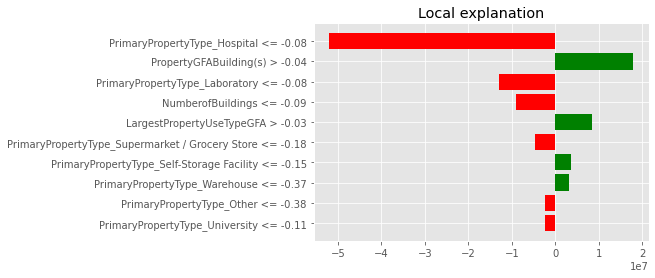

In [ ]:
with plt.style.context('ggplot'):
    energy_exp.as_pyplot_figure()

### Energy Star Score Site Energy Use

In [ ]:
energyStar_energy = nonRes[['PrimaryPropertyType','Latitude','Longitude','YearBuilt','NumberofBuildings','NumberofFloors'\
            ,'PropertyGFABuilding(s)','PropertyGFAParking','LargestPropertyUseTypeGFA','SteamUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)','SiteEnergyUse(kBtu)','ENERGYSTARScore']]

In [ ]:
energyStar_energy = energyStar_energy.dropna(axis=0)

In [ ]:
energyStar_energy['YearBuilt'] = energyStar_energy['YearBuilt'].apply(fill_date)

In [ ]:
energyStar_energy['SteamUse(kBtu)'] = energyStar_energy['SteamUse(kBtu)'].apply(lambda x : 1 if x > 0 else 0 )
energyStar_energy['Electricity(kBtu)'] = energyStar_energy['Electricity(kBtu)'].apply(lambda x : 1 if x > 0 else 0 )
energyStar_energy['NaturalGas(kBtu)'] = energyStar_energy['NaturalGas(kBtu)'].apply(lambda x : 1 if x > 0 else 0 )

In [ ]:
energyStar_energy_code = pd.get_dummies(energyStar_energy ,columns=['PrimaryPropertyType','YearBuilt'])

In [ ]:
energyStar_energy_code_names = energyStar_energy_code.drop(columns = ['SiteEnergyUse(kBtu)']).columns

- Avec Energy Star Score

In [ ]:
train_EStar_energy, test_EStar_energy = train_test_split(energyStar_energy_code, test_size=0.3, random_state=0) 
Xe_train_energy, ye_train_energy, Xe_test_energy, ye_test_energy = train_EStar_energy.drop(columns = ['SiteEnergyUse(kBtu)']), train_EStar_energy['SiteEnergyUse(kBtu)'],test_EStar_energy.drop(columns = ['SiteEnergyUse(kBtu)']) ,test_EStar_energy['SiteEnergyUse(kBtu)']

In [ ]:
""" scaler = StandardScaler()
scaler.fit(Xe_train_energy)
Xe_train_energy = scaler.transform(Xe_train_energy)
Xe_test_energy = scaler.transform(Xe_test_energy) """

' scaler = StandardScaler()\nscaler.fit(Xe_train_energy)\nXe_train_energy = scaler.transform(Xe_train_energy)\nXe_test_energy = scaler.transform(Xe_test_energy) '

In [ ]:
CV_xgboost_en = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=xgboost_param_grid, cv= 5,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
CV_xgboost_en.fit(Xe_train_energy, ye_train_energy)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 400, 500],
                         'random_state': [12]},
             refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [ ]:
CV_xgboost_en.best_score_

0.6654736143860236

In [ ]:
rfr_eStar_energy = GradientBoostingRegressor(**CV_xgboost_en.best_params_)

In [ ]:
rfr_eStar_energy.fit(Xe_train_energy, ye_train_energy)

GradientBoostingRegressor(max_depth=5, max_features='auto', random_state=12)

In [ ]:
rfr_eStar_energy.score(Xe_test_energy,ye_test_energy)

0.6805041148375716

    Feature Importance                                     Feature Name
6             0.394992                        LargestPropertyUseTypeGFA
10            0.305464                                  ENERGYSTARScore
1             0.145786                                        Longitude
4             0.083757                           PropertyGFABuilding(s)
29            0.015659                              YearBuilt_1980_2000
17            0.008814           PrimaryPropertyType_Mixed Use Property
5             0.008240                               PropertyGFAParking
0             0.007567                                         Latitude
12            0.007417                     PrimaryPropertyType_Hospital
27            0.005834                              YearBuilt_1940_1960
23            0.003121  PrimaryPropertyType_Supermarket / Grocery Store
18            0.002634                        PrimaryPropertyType_Other
2             0.002479                                NumberofBu

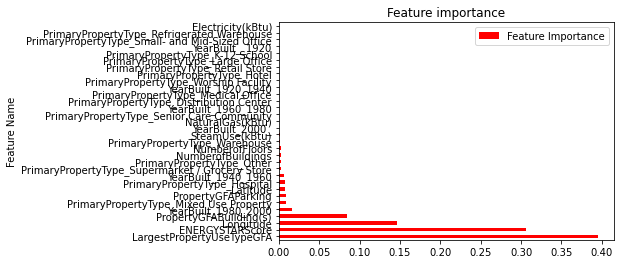

In [ ]:
def display_feat_imp_xgboost(boosted):
  feat_imp = rfr_eStar_energy.feature_importances_
  df_featimp = pd.DataFrame(feat_imp, columns = {"Feature Importance"})
  df_featimp["Feature Name"] = energyStar_energy_code_names
  df_featimp = df_featimp.sort_values(by="Feature Importance", ascending=False)
  print(df_featimp)
  df_featimp.plot.barh(y="Feature Importance", x="Feature Name", title="Feature importance", color="red")
 
display_feat_imp_xgboost(model_boosted)

- Sans Energy Star Score

In [ ]:
Xee_train_energy, yee_train_energy, Xee_test_energy, yee_test_energy = train_EStar_energy.drop(columns = ['SiteEnergyUse(kBtu)','ENERGYSTARScore']), train_EStar_energy['SiteEnergyUse(kBtu)'],test_EStar_energy.drop(columns = ['SiteEnergyUse(kBtu)','ENERGYSTARScore']) ,test_EStar_energy['SiteEnergyUse(kBtu)']

In [ ]:
CV_xgboost_en_ = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=xgboost_param_grid, cv= 5,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
CV_xgboost_en_.fit(Xee_train_energy, yee_train_energy)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 400, 500],
                         'random_state': [12]},
             refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [ ]:
CV_xgboost_en_.best_score_

0.6350891285386571